# Microsoft Malware Prediction
### W207 Final Project

* Kevin Hartman
* Gunnar Mein
* Andrew Morris

The inspiration for this project came from a recent competition from Kaggle:
* https://www.kaggle.com/c/microsoft-malware-prediction

The motivation and prompt:
> The malware industry continues to be a well-organized, well-funded market dedicated to evading traditional security measures. Once a computer is infected by malware, criminals can hurt consumers and enterprises in many ways.  With more than one billion enterprise and consumer customers, Microsoft takes this problem very seriously and is deeply invested in improving security.

> As one part of their overall strategy for doing so, Microsoft is challenging the data science community to develop techniques to predict if a machine will soon be hit with malware. As with their previous, Malware Challenge (2015), Microsoft is providing Kagglers with an unprecedented malware dataset to encourage open-source progress on effective techniques for predicting malware occurrences.

> Can you help protect more than one billion machines from damage BEFORE it happens?

## Contents

<ol>
    <li><a href='#Setup'>Definitions and Setup</a></li>
    <li><a href='#Loading'>Loading the Data</a></li>
    <li><a href='#EDA'>Exploratory Data Analysis</a></li>
    <li><a href='#Cleaning'>Data Wrangling and Cleaning</a></li>
    <li><a href='#Encoding'>Encoding and Transformations</a></li>
    <li><a href='#Features'>Feature Selection</a></li>
    <li><a href='#Models'>Model Fitting and Evaluation</a></li>
    <li><a href='#NeuralNetwork'>Neural Network</a></li>
    <li><a href='#Conclusion'>Review and Conclusion</a></li>
    <li><a href='#Appendix'>Appendix</a></li>
</ol>

We used the following classifiers that were covered in the course:

- **k Nearest Neighbors** (week 2)
- **Decision Trees**, as well as **Random Forests**, **AdaBoost**, and **Gradient Boosting** (week 4)
- **Logistic Regression** (week 5)
- **Neural Networks** (week 7)
- **Support Vector Machines** (week 8)*
- **PCA and Gaussian Mixture Models** (weeks 9 and 10)


We also investigated three experimental libraries in **HistGradientBoosting** and took a deeper dive into **PyTorch** - two topics that were not covered in the course.

We did not pursue Naive Bayes (week 3) or Stochastic Gradient Descent (week 6) due to time constraints, and because our EDA did not provide enough support to investigate these approaches.

*Of note, we performed limited LinearSVM() modeling but the results showed the model just basically guessed all positives or all negatives.  This yielded low accuracy, so we discarded this model quickly.

## Setup

Below we set up environment variables and library definitions. The environment variables indicate how the notebook will be run. 

<a href='#Contents'>[Back to top]</a>

In [8]:
# Import required libraries for subsequent operations

import re
import time
import gc
import torch
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble._hist_gradient_boosting.utils import (get_equivalent_estimator)
from sklearn.metrics import zero_one_loss
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from torch.utils import data

%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') #hide warnings that arise from missing glyphs, deprecations, etc.

# set required global flags  

load_from_encoded_files = True # skip EDA, cleaning and encoding, and load from files
use_mini_files = True # load from mini sets when loading from encoded files
do_EDA = False    # EDA portion can be skipped if working further downstream
debug = False      # use small files to check basic functionality
save_data = False # not saving encoded files can save a lot of time
generate_ids = False # if True, saves test_ids.csv
run_all_models = True # If True, run all models

# here is where we decide what to load, and trigger the process

if load_from_encoded_files:
    if use_mini_files:
        filename_encoded_train = "data/mini_train_encoded.csv"
        filename_encoded_dev = "data/mini_dev_encoded.csv"
        filename_encoded_validate = "data/mini_validate_encoded.csv"
    else:
        filename_encoded_train = "data/train_encoded.csv"
        filename_encoded_dev = "data/dev_encoded.csv"
        filename_encoded_validate = "data/validate_encoded.csv"
else:
    if debug:
        filename_train = "data/debug/mini_initial_train.csv"
        filename_test = "data/debug/mini_initial_test.csv"
    else:
        filename_train = "data/train.csv"
        filename_test = "data/test.csv"

## Loading
Utility function for loading raw files and encoded versions of those files. The actual loading process decides between small debug versions (~60MB) and the 4GB real files as indicated in our environment variable.

<a href='#Contents'>[Back to top]</a>

In [2]:
# load with pre-informed data types for faster loading

def load_from_raw_data(filename):
   
    dtypes = {
        'MachineIdentifier':                                    'str',
        'ProductName':                                          'str',
        'EngineVersion':                                        'str',
        'AppVersion':                                           'str',
        'AvSigVersion':                                         'str',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float64',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'str',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'str',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'str',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'str',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

    df = pd.read_csv(filename, dtype=dtypes, engine='c')
    return df

def load_from_encoded_data(filename):
   
    dtypes = {
        'MachineIdentifier':                                    'int64',
        'ProductName':                                          'int64',
        'EngineVersion':                                        'int64',
        'AppVersion':                                           'int64',
        'AvSigVersion':                                         'int64',
        'RtpStateBitfield':                                     'int64',
        'Platform':                                             'int64',
        'Processor':                                            'int64',
        'OsVer':                                                'int64',
        'OsPlatformSubRelease':                                 'int64',
        'OsBuildLab':                                           'int64',
        'SkuEdition':                                           'int64',
        'SmartScreen':                                          'int64',
        'Census_MDC2FormFactor':                                'int64',
        'Census_DeviceFamily':                                  'int64',
        'Census_PrimaryDiskTypeName':                           'int64',
        'Census_ChassisTypeName':                               'int64',
        'Census_PowerPlatformRoleName':                         'int64',
        'Census_InternalBatteryType':                           'int64',
        'Census_OSVersion':                                     'int64',
        'Census_OSArchitecture':                                'int64',
        'Census_OSBranch':                                      'int64',
        'Census_OSEdition':                                     'int64',
        'Census_OSSkuName':                                     'int64',
        'Census_OSInstallTypeName':                             'int64',
        'Census_OSWUAutoUpdateOptionsName':                     'int64',
        'Census_GenuineStateName':                              'int64',
        'Census_ActivationChannel':                             'int64',
        'Census_FlightRing':                                    'int64',
        'RtpStateBitfield_wasna':                               'int64',
        'DefaultBrowsersIdentifier_wasna':                      'int64',
        'AVProductStatesIdentifier_wasna':                      'int64',
        'AVProductsInstalled_wasna':                            'int64',
        'AVProductsEnabled_wasna':                              'int64',
        'CityIdentifier_wasna':                                 'int64',
        'OrganizationIdentifier_wasna':                         'int64',
        'GeoNameIdentifier_wasna':                              'int64',
        'IsProtected_wasna':                                    'int64',
        'SMode_wasna':                                          'int64',
        'IeVerIdentifier_wasna':                                'int64',
        'Firewall_wasna':                                       'int64',
        'UacLuaenable_wasna':                                   'int64',
        'Census_OEMNameIdentifier_wasna':                       'int64',
        'Census_OEMModelIdentifier_wasna':                      'int64',
        'Census_ProcessorCoreCount_wasna':                      'int64',
        'Census_ProcessorManufacturerIdentifier_wasna':         'int64',
        'Census_ProcessorModelIdentifier_wasna':                'int64',
        'Census_PrimaryDiskTotalCapacity_wasna':                'int64',
        'Census_SystemVolumeTotalCapacity_wasna':               'int64',
        'Census_TotalPhysicalRAM_wasna':                        'int64',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches_wasna': 'int64',
        'Census_InternalPrimaryDisplayResolutionHorizontal_wasna': 'int64',
        'Census_InternalPrimaryDisplayResolutionVertical_wasna': 'int64',
        'Census_InternalBatteryNumberOfCharges_wasna':          'int64',
        'Census_OSInstallLanguageIdentifier_wasna':             'int64',
        'Census_IsFlightingInternal_wasna':                     'int64',
        'Census_IsFlightsDisabled_wasna':                       'int64',
        'Census_ThresholdOptIn_wasna':                          'int64',
        'Census_FirmwareManufacturerIdentifier_wasna':          'int64',
        'Census_IsWIMBootEnabled_wasna':                        'int64',
        'Census_IsVirtualDevice_wasna':                         'int64',
        'Census_IsAlwaysOnAlwaysConnectedCapable_wasna':        'int64',
        'Wdft_IsGamer_wasna':                                   'int64',
        'Wdft_RegionIdentifier_wasna':                          'int64',
        'Census_FirmwareVersionIdentifier_wasna':               'int64',
        'OsBuildLab_platform':                                  'float64',
        'OsBuildLab_release':                                   'float64',
        'IsBeta':                                               'int8',
        'IsSxsPassiveMode':                                     'int8',
        'HasTpm':                                               'int8',
        'AutoSampleOptIn':                                      'int8',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'HasDetections':                                        'int8',
        'CountryIdentifier':                                    'float64',
        'LocaleEnglishNameIdentifier':                          'float64',
        'OsBuild':                                              'float64',
        'OsSuite':                                              'int16',
        'Census_OSBuildNumber':                                 'float64',
        'Census_OSUILocaleIdentifier':                          'float64',
        'EngineVersion_major':                                  'int16',
        'EngineVersion_minor':                                  'int16',
        'EngineVersion_build1':                                 'int16',
        'EngineVersion_build2':                                 'int16',
        'AppVersion_major':                                     'int16',
        'AppVersion_minor':                                     'int16',
        'AppVersion_build1':                                    'int16',
        'AppVersion_build2':                                    'int16',
        'AvSigVersion_major':                                   'int16',
        'AvSigVersion_minor':                                   'int16',
        'AvSigVersion_build1':                                  'int16',
        'AvSigVersion_build2':                                  'int16',
        'Census_OSVersion_major':                               'int16',
        'Census_OSVersion_minor':                               'int16',
        'Census_OSVersion_build1':                              'int16',
        'Census_OSVersion_build2':                              'int16',
        'OsVer_major':                                          'int16',
        'OsVer_minor':                                          'int16',
        'OsVer_build1':                                         'int16',
        'OsVer_build2':                                         'int16',
        'OsBuildLab_major':                                     'float64',
        'OsBuildLab_minor':                                     'float64',
        'Census_OSBuildRevision':                               'int32',
        'OsBuildLab_build1':                                    'int32',
        'OsBuildLab_build2':                                    'float64',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float64',
        'IsProtected':                                          'float16',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float64',
        'Firewall':                                             'float16',
        'Census_ProcessorCoreCount':                            'float64',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_OSInstallLanguageIdentifier':                   'float64',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float64',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float64',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float64',
        'CityIdentifier':                                       'float64',
        'Census_OEMNameIdentifier':                             'float64',
        'Census_OEMModelIdentifier':                            'float64',
        'Census_ProcessorModelIdentifier':                      'float64',
        'Census_TotalPhysicalRAM':                              'float64',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float64',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float64',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float64',
        'Census_FirmwareVersionIdentifier':                     'float64',
        'UacLuaenable':                                         'float64',
        'Census_PrimaryDiskTotalCapacity':                      'float64',
        'Census_SystemVolumeTotalCapacity':                     'float64',
        'Census_InternalBatteryNumberOfCharges':                'float64',
        'EngineVersion_combined':                               'float64',
        'AppVersion_combined':                                  'float64',
        'AvSigVersion_combined':                                'float64',
        'Census_OSVersion_combined':                            'float64',
        'OsVer_combined':                                       'float64',
        'OsBuildLab_combined':                                  'float64'
        }

    df = pd.read_csv(filename, dtype=dtypes, engine='c', header=0)
    return df

In [3]:
if load_from_encoded_files:
    df_train = load_from_encoded_data(filename_encoded_train)
    train_labels = df_train['HasDetections']
    df_dev = load_from_encoded_data(filename_encoded_dev)
    dev_labels = df_dev['HasDetections']
    df_validate = load_from_encoded_data(filename_encoded_validate)
    validate_labels = df_validate['HasDetections']
else:
    train_df = load_from_raw_data(filename_train) 
    test_df = load_from_raw_data(filename_test)
    test_df['HasDetections'] = np.int8(2)
    full_df = pd.concat([train_df, test_df]) # make full, big dataframe for analysis  

## EDA

<a href='#Contents'>[Back to top]</a>

Below we have an Analysis class that generates useful categorical information about each variable. It also displays frequencies of values in different hues as the values relate to the target. We would use this information to gain insights for cleaning and ideas for feature selection / engineering.

In short, we do this to "get to know" our data a little better.

In [7]:
# Custom-made class to assist with EDA on this dataset
# The code is generalizable. However, specific decisions on plot types were made because
# all our features are categorical
class Analyze:
    def __init__(self, df):
        self.df = df.copy()
    
    def remove_df():
        self.df = None
        gc.collect()
        
    def print_eda_summary(self):
        #sns.set(rc={'figure.figsize':(10*2,16*8)})
        sns.set()
        i=0
        fig, ax = plt.subplots(nrows=round(len(self.df.columns)), ncols=2, figsize=(16,5*round(len(self.df.columns))))
        all_cols=[]
        for col in self.df.columns:
            #if col == 'MachineIdentifier': continue
            if self.df[col].dtype.name == 'object'  or self.df[col].dtype.name == 'category': 
                self.df[col] = self.df[col].astype('str')
            all_cols.append(col)
            max_len = self.df[col].nunique()
            if max_len > 10:
                max_len = 10
            g=sns.countplot(y=self.df[col].fillna(-1), hue=self.df['HasDetections'], order=self.df[col].fillna(-1).value_counts(dropna=False).iloc[:max_len].index, ax=ax[i][0])
            g.set_xlim(0,self.df.shape[0])
            plt.tight_layout()
            ax[i][0].title.set_text(col)
            ax[i][0].xaxis.label.set_visible(False)
            xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
            g.set_xticklabels(xlabels)
            ax[i][1].axis("off")
            # Basic info
            desc = self.df[col].describe()
            summary = "DESCRIPTION\n   Name: {:}\n   Type: {:}\n  Count: {:}\n Unique: {:}\nMissing: {:}\nPercent: {:2.3f}".format(
                desc.name.ljust(50), str(desc.dtype).ljust(10), self.df[col].count(), self.df[col].nunique(),
                ('yes' if self.df[col].hasnans else 'no'), (1-self.df[col].count()/self.df.shape[0])*100)
            ax[i][1].text(0, 1, summary, verticalalignment="top", family='monospace', fontsize=12)
            analysis=[]
            if self.df[col].dtype.name == 'object': 
                # additional analysis for categorical variables
                if len(self.df[col].str.lower().unique()) != len(self.df[col].unique()):
                    analysis.append("- duplicates from case\n")
                # look for HTML escape characters (&#x..;)
                # and unicode characters (searching for: anything not printable)
                self.df_bad = self.df[col][self.df[col].str.contains(r'[\x00-\x1f]|&#x\d\d;', regex=True, na=True)]
                if len(self.df_bad) - self.df.shape[0] - self.df[col].count()>0:
                    analysis.append("- illegal chars: {:}\n".format(len(self.df_bad) - self.df.shape[0] - self.df[col].count()))
                # find different capitalizations of "unknown"
                # if more than one present, need to read as string, turn to lowercase, then make categorical
                self.df_unknown = self.df[col].str.lower() == 'unknown'
                unknowns = self.df[col][self.df_unknown].unique()
                if len(unknowns) > 1:
                    analysis.append("- unknowns\n  {:}\n".format(unknowns))
                if len(''.join(analysis)) > 0:
                    ax[i][1].text(.5, .85, 'FINDINGS\n'+''.join(analysis), verticalalignment="top", family='monospace', fontsize=12)
            else:
                # Stats for numeric variables
                statistics = "STATS\n   Mean: {:5.4g}\n    Std: {:5.4g}\n    Min: {:5.4g}\n    25%: {:5.4g}\n    50%: {:5.4g}\n    75%: {:5.4g}\n    Max: {:5.4g}".format(
                    desc.mean(), desc.std(), desc.min(), desc.quantile(.25), desc.quantile(.5), desc.quantile(.75), desc.max())
                ax[i][1].text(.5, .85, statistics, verticalalignment="top", family='monospace', fontsize=12)

            # Top 5 and bottom 5 unique values or all unique values if < 10
            if self.df[col].nunique() <= 10:
                values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).keys().tolist(),
                                         self.df[col].value_counts(dropna=False).tolist())),
                                columns=['VALUES', 'COUNTS'])
                values = values.to_string(index=False)
                ax[i][1].text(0, .6, values, verticalalignment="top", family='monospace', fontsize=12)
            else:
                values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).iloc[:5].keys().tolist(),
                                         self.df[col].value_counts(dropna=False).iloc[:5].tolist())),
                                columns=['VALUES', 'COUNTS'])
                mid_row = pd.DataFrame({'VALUES':[":"],
                                        'COUNTS':[":"]})
                bot_values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).iloc[-5:].keys().tolist(),
                                         self.df[col].value_counts(dropna=False).iloc[-5:].tolist())),
                                columns=['VALUES', 'COUNTS'])
                values = values.append(mid_row)
                values = values.append(bot_values)
                values = values.to_string(index=False)
                ax[i][1].text(0, .6, values, verticalalignment="top", family='monospace', fontsize=12)
            i=i+1
        fig.show()

### Analyze the datasets
Below are the results of our inline EDA plots and summary information. We show information for both train and test sets so we can observe directionality of variable frequencies. Had we more time we would have liked to have investigated this directionality a little more. 

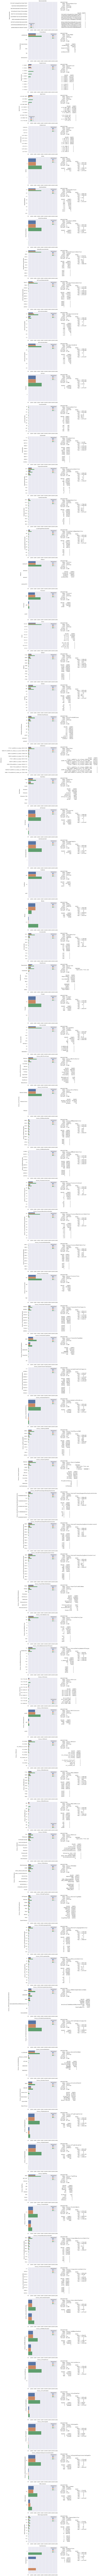

In [8]:
if do_EDA:
    analyzer = Analyze(full_df)
    analyzer.print_eda_summary()


Below are our raw notes from analysis; to inform cleaning, encoding and feature selection. Note we did not implement each of the ideaas illustrated, but present them as places where we can go next.

* Fields with largely missing values:
 * PuaMode - missing 99.9% of the data - remove
 * Census_ProcessorClass - 99.5% missing - remove
 * DefaultBrowsersIdentifier - 95% missing - probably would correlate well with malware but its all missing - remove 
 * Census_IsFlightingInternal - 83 missing (21 are 1s and rest are 0) - remove
 * Census_InternalBatteryType - 70% missing - battery correlates to malware how? - remove
* Binary fields
 * Census_IsWIMBootEnabled - It is 0 or missing. One value is set to 1. Recode the 1 as a "missing" and make this a binary field?
 * Census_IsFlightsDisabled - Mostly 0s. 2% are missing. 88 are 1s. Recode the 1 as "missing" and then it becomes a binary field?
 * Census_IsPortableOperatingSystem - Mostly 0s - remove
 * IsBeta - mostly 0s. 67 are 1s. - remove
 * AutoSampleOptIn - Mostly 0s. - remove
* Other fields
 * UacLuaenable - Mostly 1s. Zero out the rest and turn into a binary field.
 * AvProductsInstalled - Bin 4,5,6 and 7 into one bin. Move 0 and the missings together.
 * AvProductsEnabled - Bin 4 and 5 together. 
 * RtpStateBitField - Bin 3, 1 and 35 together with the missing category.
 * SmartScreen - Bin the garbage and low frequency values with the missing category. Correct spellings on the others.
 * Census_ProcessorCoreCount - could bin but need to probe in further to see how
 * Census_ProcessorManufacturerIdentifier - bin 10, 3, 9, 7 and 4 with the missing category.
 * Census_InternalPrimaryDiagonalDisplaySizeInInches - bin these by real inches w/o the fractions - need to probe in further
 * Census_InternalPrimaryDisplayResolutionHorizontal - same as above
 * Census_InternalPrimaryDisplayResolutionVertical - same as above
 * Census_GenuineStateName - Bin TAMPERED with UNKNOWN
 * Census_FlightRing - Bin Invalid with Unknown
 * Census_PrimaryDiskTotalCapacity - Bin this by range?
 * Census_SystemVolumeTotalCapacity - Same as above
 * Census_TotalPhysicalRam - Same as above
 * Census_ChassisTypeName - Look into binning
 
 

In [9]:
# clean up and garbage collect the big dataframe for analysis - we don't need it anymore 
if do_EDA:
    analyzer.remove_df
    analyzer = None
    gc.collect()

### Large Heatmap

In [ ]:
if do_EDA:
    sns.set(rc={'figure.figsize':(100,100)})
    sns.heatmap(df_train.corr(), cmap='RdBu_r', annot=True, center=0.0)

## Cleaning

Next is our cleaning routines. Get out the broom. In this section we fix common issues we see with the data and remove variables that provide limited value outright. We also perform one-hot encoding for missing values, and introduced a categorical value of 'unknown' for string fields that were missing.

We also perform light feature engineering in this step as we identified a desire to preserve the version information in a numerical value equivalent as we did not necessarily want to rely on ordinal positions in label encoding. Invariably we had both types of features to choose from, and the feature selection process did not bear usage of the version fields. In a future iteration we would like to pursue a frequency encoding strategy for these fields as a next option to try.

<a href='#Contents'>[Back to top]</a>


In [10]:
def clean_data(df):  
    
    #
    # drop certain useless columns
    #
    
    df = df.drop(columns=['PuaMode','Census_ProcessorClass'])
    
    #
    # make all strings lower case
    # get rid of hex char codes, keep the actual code number
    #
    
    char_treatment = [
        'AvSigVersion',
        'SmartScreen',
        'Census_InternalBatteryType'
    ]
    
    case_treatment = [
        'SmartScreen',
        'Census_ChassisTypeName',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName',
        'Census_GenuineStateName'
    ]
    
    print("-- replacing weird characters ...")
    for col in char_treatment:
        if df[col].dtype.name == 'object':
            df[col] = df[col].str.replace(r'&#x(\d\d);', '\1', regex=True)
            df[col] = df[col].str.replace(r'[\x00-\x1f]', '', regex=True)
        else:
            print("col", col,"flagged for char replacement is not of type string")
            
    print("-- lower-casing where appropriate ...")
    for col in case_treatment:
        if df[col].dtype.name == 'object':
            df[col] = df[col].str.lower()
             
    #
    # Fix SmartScreen discrepencies
    # TODO: Decide what to do with the garbage fields
    #           
    df.replace({'SmartScreen':
        {'Enabled':'on',
         'RequiredAdmin':'requireadmin',
         'of':'off',
         'Promt':'prompt',
         'Promprt':'prompt'}})
            
    #
    # make strings into categories
    #
    
    categories = [
        'SmartScreen',
        'Census_InternalBatteryType',
        'Census_ChassisTypeName',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName',
        'OsBuildLab'
    ]
    
    print("-- making categories from strings that needed massaging ...")
    for col in categories:
        df[col] = df[col].astype('category')


        
    #
    # add 'unknown' categories where necessary and replace the NAs
    # ADD COLUMNS NAMES HERE TO HAVE THEIR CATEGORIES AUGMENTED AND NAS FILLED WITH 'unknown'
    #
    
    categories = [
        'SmartScreen',
        'Census_PrimaryDiskTypeName',  # ['HDD' 'SSD' 'UNKNOWN' 'Unspecified']
        'Census_InternalBatteryType',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName', # also had 'unknown' as well as Nas
        'Census_GenuineStateName',       # and this one too
        'Census_ChassisTypeName'
        
    ]

    print("-- adding categories ..")
    for col in categories:
        print("   ", col)
        if 'unknown' not in df[col].cat.categories:
            df[col].cat.add_categories(['unknown'], inplace=True)
        df[col].fillna('unknown', inplace=True)
    # add one manually because it needs a special unknown value
    df["OsBuildLab"].cat.add_categories(["0.0.-.-.0-0"], inplace=True)
    df["OsBuildLab"].fillna("0.0.-.-.0-0", inplace=True)
    # and this one already had some 'unknown' values
    #df['Census_ChassisTypeName'].fillna('unknown', inplace=True)



    #
    # flag and fill selected NAs
    # ADD COLUMN NAMES HERE IN nafill TO HAVE COLUMNS FLAGGED AND FILLED WITH PROVIDED VALUES
    #
    
    print("-- replacing selected NA values")
    nafill = {
        "RtpStateBitfield":0,
        "DefaultBrowsersIdentifier":0,
        "AVProductStatesIdentifier":0,
        "AVProductsInstalled":0,
        "AVProductsEnabled":0,
        "CityIdentifier":0,
        "OrganizationIdentifier":0,
        "GeoNameIdentifier":0,
        "IsProtected":0,
        "SMode":0,
        "IeVerIdentifier":0,
        "Firewall":0,
        "UacLuaenable":0,
        "Census_OEMNameIdentifier":0,
        "Census_OEMModelIdentifier":0,
        "Census_ProcessorCoreCount":0,
        "Census_ProcessorManufacturerIdentifier":0,
        "Census_ProcessorModelIdentifier":0,
        "Census_PrimaryDiskTotalCapacity":0,
        "Census_SystemVolumeTotalCapacity":0,
        "Census_TotalPhysicalRAM":0,
        "Census_InternalPrimaryDiagonalDisplaySizeInInches":0,
        "Census_InternalPrimaryDisplayResolutionHorizontal":0,
        "Census_InternalPrimaryDisplayResolutionVertical":0,
        "Census_InternalBatteryNumberOfCharges":0,
        "Census_OSInstallLanguageIdentifier":0,
        "Census_IsFlightingInternal":0,
        "Census_IsFlightsDisabled":0,
        "Census_ThresholdOptIn":0,
        "Census_FirmwareManufacturerIdentifier":0,
        "Census_IsWIMBootEnabled":0,
        "Census_IsVirtualDevice":0,
        "Census_IsAlwaysOnAlwaysConnectedCapable":0,
        "Wdft_IsGamer":0,
        "Wdft_RegionIdentifier":0,
        "Census_FirmwareVersionIdentifier":0
    }

    for col in nafill:
        df[col+'_wasna'] = df[col].isna()
    df.fillna(value=nafill, inplace=True)
    
    #
    # then some of these columns can become ints, not floats
    #

    print("-- converting columns to int ...")
    df['RtpStateBitfield'] = df['RtpStateBitfield'].astype(np.uint8)

    #
    # deal with version numbers
    #
    
    print("-- mapping version numbers ...")
    def map_OsVer(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000.0*df[col+'_major']+100.0*df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/1000.0

    # e.g. 10.0.10240.16397
    def map_CensusOSVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 1000000.0*df[col+'_major']+df[col+'_minor']*10000+(df[col+'_build1'])+(df[col+'_build2'])/100000.0

    # e.g. 1.235.2586.0
    def map_AvSigVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000.0*df[col+'_major']+df[col+'_minor']+(df[col+'_build1'])/10000.0+(df[col+'_build2'])/10000000.0


    # e.g. 4.12.17007.18022
    def map_AppVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000000.0*df[col+'_major']+100000.0 * df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/100000.0

    # e.g. 1.1.12902.0
    def map_EngineVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 100000000.0*df[col+'_major']+1000000.0*df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/10000.0

    def map_OsBuildLab(df, col):
        series = df[col].astype(str).str.replace('*', '.', regex=False)
        df_split = series.str.split(".", n=4, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_platform'] = df_split[2].astype('category')
        df[col+'_release'] = df_split[3].astype('category')
        df_build = df_split[4].str.split("-", n=1, expand=True)
        df[col+'_build1'] = df_build[0].astype(np.int32)
        df[col+'_build2'] = df_build[1].astype(np.int32)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 1000000.0*df['OsBuildLab_major']+10.0*df['OsBuildLab_minor']+df['OsBuildLab_build1']/100000.0+df['OsBuildLab_build2']/10000000000.0
        df_split = None
        df_build = None

    map_EngineVersion(df, "EngineVersion")
    map_AppVersion(df, "AppVersion")
    map_AvSigVersion(df, "AvSigVersion")
    map_CensusOSVersion(df, "Census_OSVersion")
    map_OsVer(df, "OsVer")
    map_OsBuildLab(df, "OsBuildLab")    
    
    gc.collect()
    
    return df

In [11]:
#
# this triggers the cleaning process
#
if not load_from_encoded_files:
    cleaned_df = clean_data(full_df)

-- replacing weird characters ...
-- lower-casing where appropriate ...
-- making categories from strings that needed massaging ...
-- adding categories ..
    SmartScreen
    Census_PrimaryDiskTypeName
    Census_InternalBatteryType
    Census_OSEdition
    Census_PowerPlatformRoleName
    Census_GenuineStateName
    Census_ChassisTypeName
-- replacing selected NA values
-- converting columns to int ...
-- mapping version numbers ...


## Encoding

<a href='#Contents'>[Back to top]</a>

Next step is to encode data by applying a StandardScalar for numerical categorical variables and a LabelEncoder for string categorical variables. We noted early on that our data set consists of mostly categorical variables.

In [12]:
class Encoder:
    def __init__(self, df): #in_file):
        self.df = df #pd.read_csv(in_file, dtype=dtypes)
        #print("Completed read operation for", in_file)
        #self.reduce_mem()
        gc.collect()
        self.make_subsets(self.df)
        self.encode_it()
        self.transform_df(self.df, self.nominal_cols)
        self.std_norm()
        
    
    def reduce_mem(self, verbose=True):
        start_mem = self.df.memory_usage().sum() / 1024**2
        print('-- attempting to reduce memory. memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in self.df.columns:
            col_type = self.df[col].dtype

            if col_type != object and str(col_type) != 'category':
                c_min = self.df[col].min()
                c_max = self.df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        self.df[col] = self.df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        self.df[col] = self.df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        self.df[col] = self.df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        self.df[col] = self.df[col].astype(np.int64)  
                # leave floats alone because the downcasting is messing up our mapped values
                #else:
                #    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #        df[col] = df[col].astype(np.float16)
                #    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                #        df[col] = df[col].astype(np.float32)
                #    else:
                #        df[col] = df[col].astype(np.float64)
                else:
                    if str(col_type)[:5] != 'float':
                        self.df[col] = self.df[col].astype('category')

        end_mem = self.df.memory_usage().sum() / 1024**2
        print('-- memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('-- decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return self.df

    def make_subsets(self, df):
        print("-- making subsets ...")
        numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        self.numeric_cols = [c for c,v in self.df.dtypes.items() if v in numerics and c in self.df.columns]
        self.nominal_cols = [c for c in self.df.columns if (c not in self.numeric_cols)]
        self.binary_cols = [c for c in self.df.columns if (self.df[c].nunique() == 2 and c not in self.nominal_cols)]
        self.unary_cols = [c for c in self.df.columns if (self.df[c].nunique() == 1 and c not in self.nominal_cols)]
        if "HasDetections" in df.columns:
            self.labels = df["HasDetections"].values
        print("-- subsets are complete")
        return

    def transform_df(self, in_df, nominal_cols):
        print("-- datatype transformation ...")
        le = preprocessing.LabelEncoder()
        tmp_df = in_df[nominal_cols].apply(le.fit_transform)
        for c in in_df.loc[:, in_df.dtypes == np.int8].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int16].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int32].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int64].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float16].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float32].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float64].columns:
            tmp_df[c] = in_df[c]
        for c in in_df[in_df.select_dtypes(bool).columns]:
            tmp_df[c] = in_df[c]
        self.df = tmp_df
        print("-- completed transforming dtypes")
        return

    def std_norm(self):
        print("-- scaling ...")
        col_to_std = ['AVProductStatesIdentifier',
                      'CountryIdentifier',
                      'CityIdentifier',
                      'GeoNameIdentifier',
                      'LocaleEnglishNameIdentifier',
                      'OsBuild',
                      'IeVerIdentifier',
                      'Census_OEMNameIdentifier',
                      'Census_OEMModelIdentifier',
                      'Census_ProcessorCoreCount',
                      'Census_ProcessorModelIdentifier',
                      'Census_PrimaryDiskTotalCapacity',
                      'Census_SystemVolumeTotalCapacity',
                      'Census_TotalPhysicalRAM',
                      'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                      'Census_InternalPrimaryDisplayResolutionHorizontal',
                      'Census_InternalPrimaryDisplayResolutionVertical',
                      'Census_InternalBatteryNumberOfCharges',
                      'Census_OSBuildNumber',
                      'Census_OSInstallLanguageIdentifier',
                      'Census_OSUILocaleIdentifier',
                      'Census_FirmwareManufacturerIdentifier',
                      'Census_FirmwareVersionIdentifier',
                      'Wdft_RegionIdentifier',
                      'OsBuildLab_major',
                      'OsBuildLab_minor',
                      'OsBuildLab_platform',
                      'OsBuildLab_release',
                      'OsBuildLab_build2']
        scaled_features = self.df.copy()
        features = scaled_features[col_to_std]
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)
        scaled_features[col_to_std] = features
        self.df = scaled_features
        print("-- completed standardization and normalization")
        return
    
    def encode_it(self):
        print("-- label encoding ...")
        le = preprocessing.LabelEncoder()
        for n in self.nominal_cols:
            #print(" ...",n)
            self.df[n] = le.fit_transform(self.df[n])
        print("-- completed label encoding")
        return
    
    def get_encoded_data(self):
        return self.df

In [13]:
# helper function for generating our dtypes for loading the file back when we need it
def dump_final_types(df):
    for dtype in df.dtypes.items():
        print("'{:} '{:}',".format((dtype[0] + "':").ljust(54), dtype[1]))

### Encode

Below we run our encoder on the cleaned data, and get the data sets ready for saving.

In [14]:
if not load_from_encoded_files:
    encoded_full_df = Encoder(cleaned_df).get_encoded_data()

-- making subsets ...
-- subsets are complete
-- label encoding ...
-- completed label encoding
-- datatype transformation ...
-- completed transforming dtypes
-- scaling ...
-- completed standardization and normalization


Split the test and train segments back off

In [15]:
if not load_from_encoded_files:
    encoded_train_df = encoded_full_df[encoded_full_df['HasDetections'] != 2]
    encoded_test_df = encoded_full_df[encoded_full_df['HasDetections'] == 2]
    encoded_test_df = encoded_test_df.drop(columns='HasDetections')

### Splitting and Saving
And now create mini-train sets for model building (and optionally save)

In [16]:
# function to create a mini set from the supplied criteria (n, features, labels)
def generate_mini(n, features, labels):
    sample_size = n / features.shape[0]
    reserved_size = 1-sample_size
    X_mini, X_rest, y_mini, y_rest = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    return X_mini, X_rest, y_mini, y_rest

In [17]:
# function to create stratified train, dev and validate sets from supplied ratios 
def generate_train_dev_validate_sets(train_ratio, test_ratio, features, labels):
    reserved_size = 1-train_ratio
    X_train, X_rest, y_train, y_rest =  \
        train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    reserved_size = 1 - (test_ratio / reserved_size)
    X_dev, X_validate, y_dev, y_validate = \
        train_test_split(X_rest, y_rest, stratify=y_rest, test_size=reserved_size, random_state=0)
    return X_train, X_dev, X_validate, y_train, y_dev, y_validate

In [18]:
#
# function for saving encoded frames
#
def save_encoded_files(df, name):
    
    # save the file
    df.to_csv("data/"+name+"_encoded.csv", index=False, header=True)
    

In [19]:
if not load_from_encoded_files:
    start = time.time()
    
    # generate stratified data sets using supplied ratios to create the sets
    df_train, df_dev, df_validate, train_labels, dev_labels, validate_labels = \
        generate_train_dev_validate_sets(.7, .15, encoded_train_df, encoded_train_df['HasDetections'])

    #
    # create mini_ files for model development
    #
    mini_ratio = .05

    mini_train, remaining, mini_train_labels, remaining_labels = \
        generate_mini(df_train.shape[0]*mini_ratio, df_train, df_train['HasDetections'])

    mini_dev, remaining, mini_dev_labels, remaining_labels = \
        generate_mini(df_dev.shape[0]*mini_ratio, df_dev, df_dev['HasDetections'])

    mini_validate, remaining, mini_validate_labels, remaining_labels = \
        generate_mini(df_validate.shape[0]*mini_ratio, df_validate, df_validate['HasDetections'])

    print("shape of mini_train:",mini_train.shape)
    print("shape of mini_dev:",mini_dev.shape)
    print("shape of mini_validate:",mini_validate.shape)
    print("\nchecking symmetric difference between mini_dev and mini_train:", len(set(mini_train['MachineIdentifier']).symmetric_difference(mini_dev['MachineIdentifier'])))
    print("-- total unique machine ids after recombining both sets:", pd.concat([mini_train['MachineIdentifier'], mini_dev['MachineIdentifier']]).nunique())
    print("-- original length of mini_dev + length of mini_train:", mini_dev.shape[0] + mini_train.shape[0])
    print("\nchecking symmetric difference between mini_validate and mini_train:", len(set(mini_train['MachineIdentifier']).symmetric_difference(mini_validate['MachineIdentifier'])))
    print("-- total unique machine ids after recombining both sets:", pd.concat([mini_train['MachineIdentifier'], mini_validate['MachineIdentifier']]).nunique())
    print("-- original length of mini_validate + length of mini_train:", mini_validate.shape[0] + mini_train.shape[0])
    print("\nchecking symmetric difference between mini_dev and mini_validate:", len(set(mini_dev['MachineIdentifier']).symmetric_difference(mini_validate['MachineIdentifier'])))
    print("-- total unique machine ids after recombining both sets:", pd.concat([mini_dev['MachineIdentifier'], mini_validate['MachineIdentifier']]).nunique())
    print("-- original length of mini_dev + length of mini_validate:", mini_validate.shape[0] + mini_dev.shape[0])
    print("\ndone making mini sets")
    print("seconds elapsed:", time.time()-start)

shape of mini_train: (312251, 149)
shape of mini_dev: (66911, 149)
shape of mini_validate: (66911, 149)

checking symmetric difference between mini_dev and mini_train: 379162
-- total unique machine ids after recombining both sets: 379162
-- original length of mini_dev + length of mini_train: 379162

checking symmetric difference between mini_validate and mini_train: 379162
-- total unique machine ids after recombining both sets: 379162
-- original length of mini_validate + length of mini_train: 379162

checking symmetric difference between mini_dev and mini_validate: 133822
-- total unique machine ids after recombining both sets: 133822
-- original length of mini_dev + length of mini_validate: 133822

done making mini sets
seconds elapsed: 121.31013703346252


Save off our mini train, dev and validate files

In [20]:
#
# save encoded mini files
# save function will add "data/" and "_encoded.csv"
#

if not load_from_encoded_files and save_data:
    print("saving mini_train_encoded ...")
    save_encoded_files(mini_train, "mini_train")
    print("saving mini_dev_encoded ...")
    save_encoded_files(mini_dev, "mini_dev")
    print("saving mini_validate_encoded ...")
    save_encoded_files(mini_validate, "mini_validate")
    print("done saving mini files")
    print("seconds elapsed:", time.time()-start)



Save the full files. We don't want to go through the above steps again if we can avoid it.

In [21]:
#
# save encoded full files
# save function will add "data/" and "_encoded.csv"
#

if not load_from_encoded_files and save_data:
    print("saving train_encoded ...")
    save_encoded_files(df_train, "train")
    print("done saving encoded train file")

    print("saving dev_encoded ...")
    save_encoded_files(df_dev, "dev")
    print("done saving encoded dev file")

    print("saving validate_encoded ...")
    save_encoded_files(df_validate, "validate")
    print("done saving encoded validate file")


In [22]:
#
# save large test dataset
#

if not load_from_encoded_files and save_data:
    print("saving encoded large test data ...")
    save_encoded_files(encoded_test_df, "test")
    print("done saving encoded files")
    print("seconds elapsed:", time.time()-start)
    encoded_test_df = None
    gc.collect()
    print("done saving files")

## Features

<a href='#Contents'>[Back to top]</a>

In this stage of the process we need to identify features for our models. We admit this process was iterative, and what you see below does not fully represent the cycles of our feature preperation. Rather, we highlight two of our best techniques for selection and showcase their results side by side for each model. You will note along with us that the one of the feature selection options does not offer the best results in every model. In most cases there will be one that stands out more favorably. We will review them as each of our model's results are revealed.

In [5]:
# remove labels from the data sets and re-assign to new variables
# note that train_labels, dev_labels and validate_labels are already defined

train_data = df_train.drop(columns='HasDetections')
dev_data = df_dev.drop(columns='HasDetections')
validate_data = df_validate.drop(columns='HasDetections')

### Selection of Features using correlation analysis

In this feature selection technique we use correlation data to build a list of relevent variables, and show a correlation plot for the resulting selections.

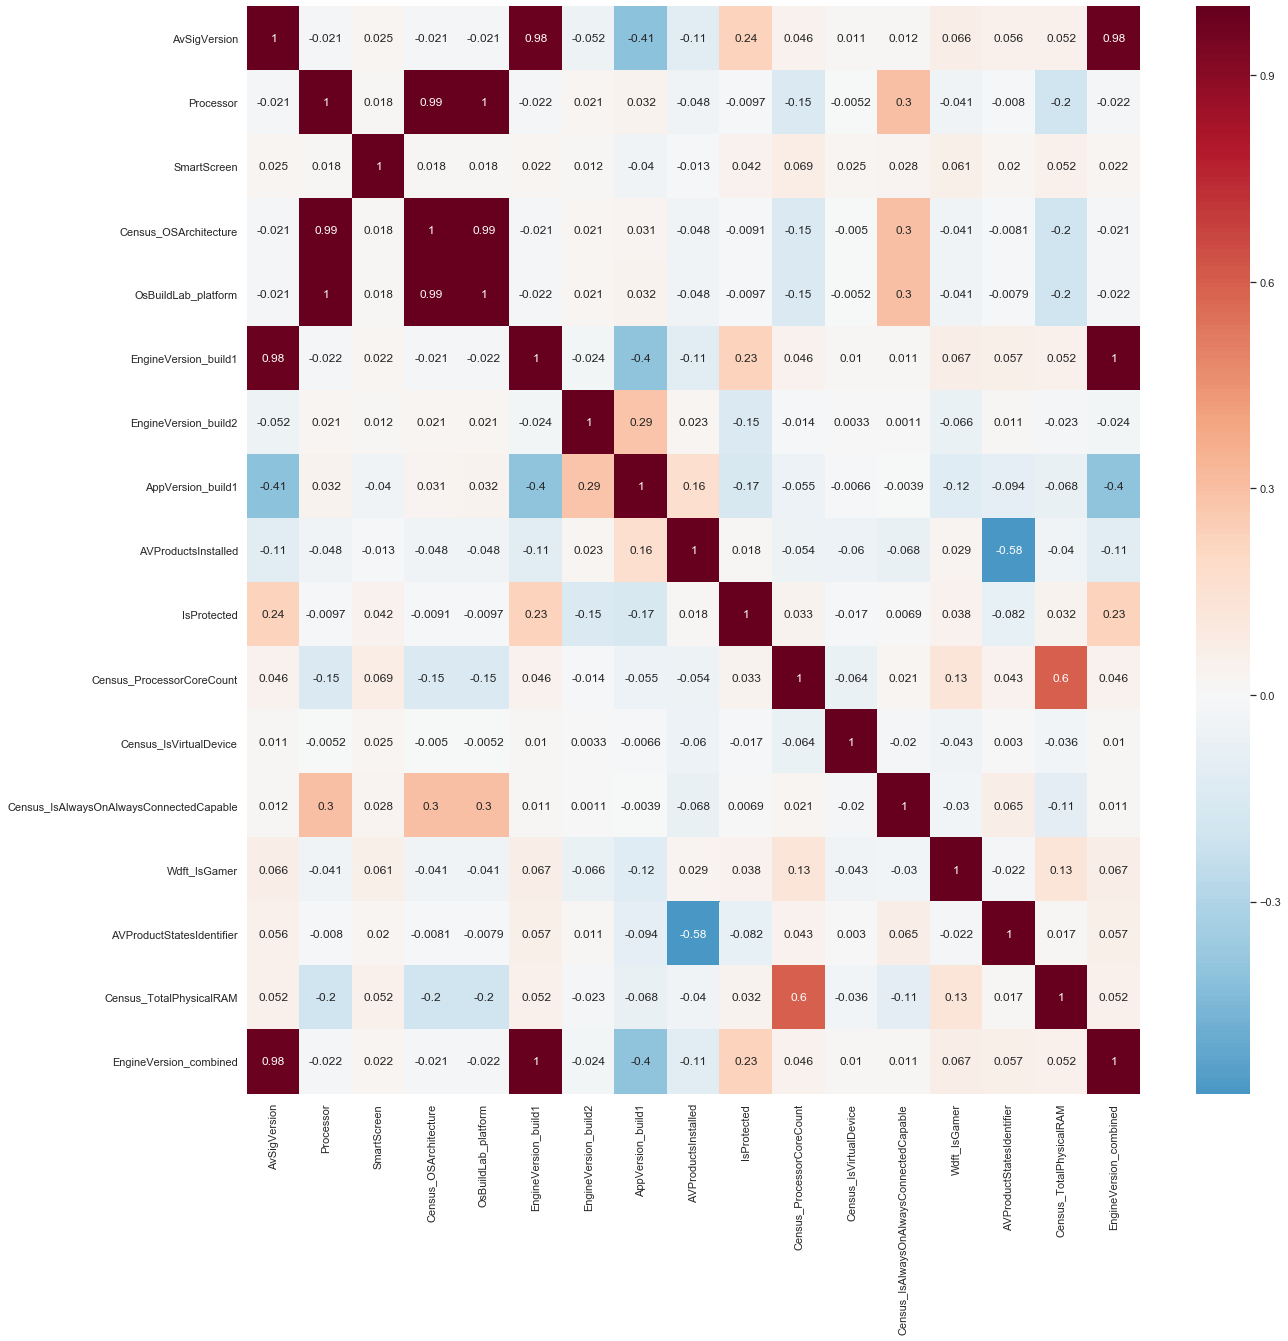

In [10]:
# find columns that correlate with the label

correlated_cols=[]
for col in train_data.columns:
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated numeric variables
        correlated_cols.append(col)
    else:
        star=''
    #print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df_train[correlated_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

In the plot above we also discover a few fields correlate strongly with one another. To avoid overfitting we will choose one. Our hueristic is to utilize our EDA and evaluate the distribution of categorical data for each of the variables and choose the one that provides the most reasonable amount of breadth.

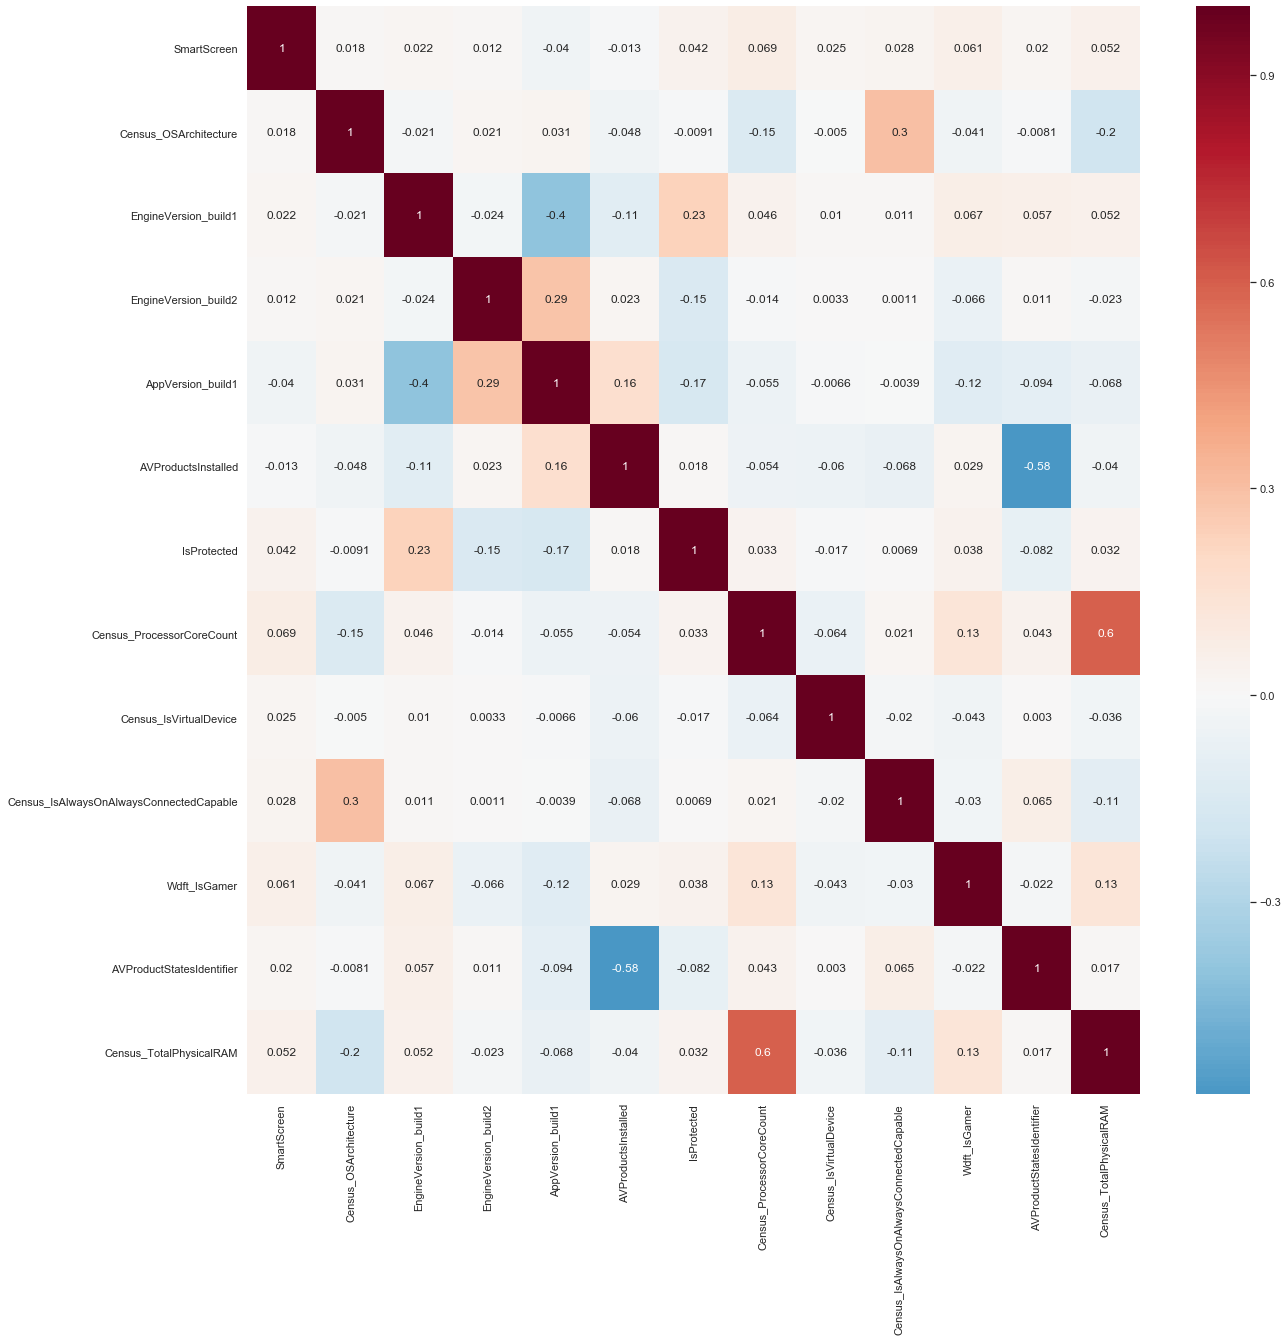

In [11]:
# Remove columns that correlate with one another from the correlation graph

# Keep EngineVersion_build1
if 'AvSigVersion' in correlated_cols:
    correlated_cols.remove('AvSigVersion')
if 'EngineVersion_combined' in correlated_cols:
    correlated_cols.remove('EngineVersion_combined')

# Note - these do not show up on the minis
if 'EngineVersion' in correlated_cols:
    correlated_cols.remove('EngineVersion')
if 'AvSigVersion_minor' in correlated_cols:
    correlated_cols.remove('AvSigVersion_minor')

# Keep Census_OSArchitecture
if 'Processor' in correlated_cols:
    correlated_cols.remove('Processor')
if 'OsBuildLab_platform' in correlated_cols:
    correlated_cols.remove('OsBuildLab_platform')

sns.heatmap(df_train[correlated_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

With our selections prepared we'll create references to them to use in model fitting.

In [12]:
# create a train, dev and validate set
X_train_data_corr = train_data[correlated_cols]
X_dev_data_corr = dev_data[correlated_cols]
X_validate_data_corr = validate_data[correlated_cols]

### Selection of Features using SelectFromModel

In this approach we will let sklearn choose the best features for us. To do this, we fit an ExtraTreesClassifier with our training data (ExtraTreesClassifier is a model we will cover later), and let SelectFromModel pull out the best options. With those selections in hand, we transform our data sets and assign new dataset variables that will utilize those dimensions.

In [13]:
fsel = ExtraTreesClassifier(n_estimators=10, n_jobs=-1).fit(train_data, train_labels)
sfm = SelectFromModel(fsel, prefit=True)
X_train_data_sfm = sfm.transform(train_data)
X_dev_data_sfm = sfm.transform(dev_data)
X_validate_data_sfm = sfm.transform(validate_data)
print('selected {:} out of {:} features'.format(
    X_train_data_sfm.shape[1], train_data.shape[1]))


selected 47 out of 148 features


### Other feature selection methods reviewed

It is worth mentioning we also investigated Ridge Regression as a feature selection technique to find the best variables (it does this by determining their coefficients and ranking by variable weight). However, Ridge Regression works beter with more linearity in the data, which we simply didn't have.

We also investigated an iterative manual process: We sorted columns by their absolute amount of correlation with the labels, and then added the top 100 columns to the models one at a time, running the model, and checking its accuracy. If the accuracy was improved from the best column set we had before, the new column would be permanently included. This approach amounts to p-value hunting on the dev set, and has some obvious flaws in that it was only the easy-to-spot linear predictors that got a chance to be added early, but it produced better results than other feature selection approaches for some models.

## Models

Finally we get to model evaluation using our two techniques for selecting features. In the sections that follow we present the results from 1) Correlation Analysis and 2) SelectFromModel.

Most of the traditional Classifiers that include Logistic, KNN, PCA/GMM and DecisionTrees all do better with the Correlation method. LinearSVC does poorly with each. But when we get to ensembling and boosting methods we see a flip where the SelectFromModel becomes a better performer, and ultimately gives us the best results.

<a href='#Contents'>[Back to top]</a>

In [14]:
def score_model(model, train_data, train_labels, score_data, score_labels):
    model.fit(X=train_data, y=train_labels)

    # predict and score on the scoring set
    pred = model.predict(score_data)
    
    cm = confusion_matrix(score_labels, pred)
    accuracy = metrics.accuracy_score(y_true=score_labels, y_pred=pred)
    
    return accuracy, cm

### Logistic Regression

One of our async lecturers said that his place of work usually ends up with logistic regression, because with a lot of data, it does almost as well as anything else. We certainly have a lot of data. This was the first model that we decided to employ.

In [15]:
# Model
model_name = "Logistic Regression"
model = LogisticRegression(solver='lbfgs', max_iter=150)

Using Feature Selection through Correlation Analysis:

In [17]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Logistic Regression using Correlated Feature Selection:

56.7% accuracy

confusion matrix
[[21406 12063]
 [16886 16556]]


Using Feature Selection through SelectFromModel

In [16]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Logistic Regression using SelectFromModel Feature Selection:

52.9% accuracy

confusion matrix
[[10103 23366]
 [ 8117 25325]]


### K-Nearest Neighbors

We also looked at KNN for comparison. KNN was covered in the second week of our course. With smaller data it does just as well (if not better) as Logistic Regression. However, attempting to train the model against a full data set will result in a local laptop in a hung state. Regardless, we start to see the results of our correlation analysis pay off. SelectFromModel has yet to prove its value.

In [27]:
# Model
model_name = "K-Nearest Neighbor Classifier"
model = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)

Using Feature Selection through Correlation Analysis

In [29]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with K-Nearest Neighbor Classifier using Correlated Feature Selection:

60.1% accuracy

confusion matrix
[[20027 13442]
 [13228 20214]]


Using Feature Selection through SelectFromModel

In [28]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with K-Nearest Neighbor Classifier using SelectFromModel Feature Selection:

51.2% accuracy

confusion matrix
[[16817 16652]
 [15968 17474]]


### Linear SVC

We include Linear SVC here and show it is no better than a coin toss against this data set. This makes sense because when we looked at plots after generating PCA components we saw the decision surface was no where near linear.

In [30]:
# Model
model_name = "Linear SVC"
model = LinearSVC()

Using Feature Selection through Correlation Analysis

In [32]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Linear SVC using Correlated Feature Selection:

50.0% accuracy

confusion matrix
[[33466     3]
 [33442     0]]


Using Feature Selection through SelectFromModel

In [31]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Linear SVC using SelectFromModel Feature Selection:

50.1% accuracy

confusion matrix
[[ 1879 31590]
 [ 1767 31675]]


### PCA

This is using PCA and then GMM clustering. We experimentally determined (in another notebook) that our most promising parameters are:<br>
PCA components = 5, GMM components = 1, covariance type = diagonal


In [90]:
# Model + Custom scorer
model_name = "PCA/GMM"

def score_pca_gmm_model (x_train, y_train, x_test, y_test):
    pca = PCA(n_components=5)
    projected = pca.fit_transform(x_train)
    projected_test = pca.transform(x_test)

    gm_mod_pos = GaussianMixture(n_components = 1, reg_covar=.0001, covariance_type='diag')
    gm_mod_pos.fit(projected[y_train==1])

    gm_mod_neg = GaussianMixture(n_components = 1, reg_covar=.0001, covariance_type='diag')
    gm_mod_neg.fit(projected[y_train==0])

    prob_pos = gm_mod_pos.score_samples(projected_test)
    prob_neg = gm_mod_neg.score_samples(projected_test)

    predictions = np.where(prob_pos >= prob_neg, 1, 0)
    accuracy = metrics.accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    return accuracy, cm

Using Feature Selection through Correlation Analysis

In [91]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_pca_gmm_model(X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)


Predicting with PCA/GMM using Correlated Feature Selection:

60.2% accuracy

confusion matrix
[[21809 11660]
 [15004 18438]]


Below we visually represent the reduction of these features from two PCA components.

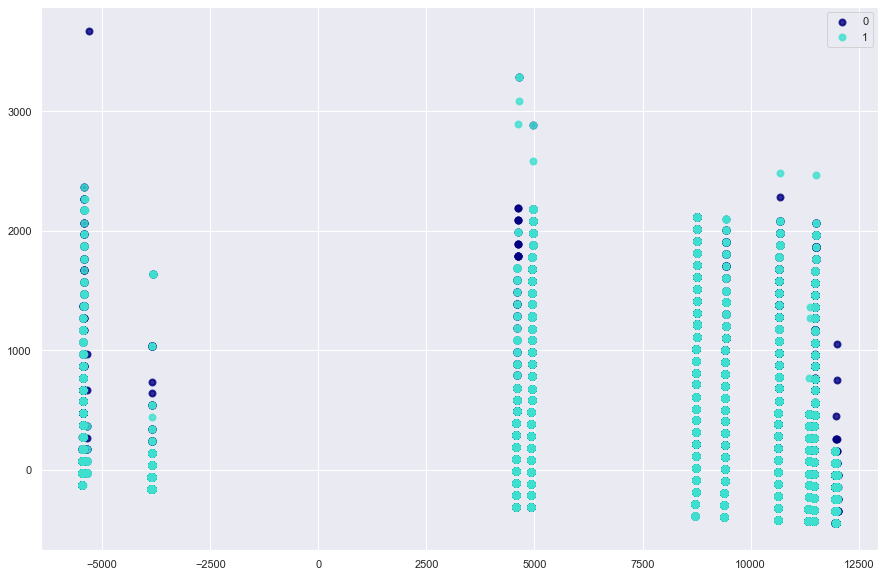

In [92]:
pca = PCA(n_components=2)
projected = pca.fit_transform(X_train)

plt.figure(figsize=(15,10))

from collections import defaultdict

category = defaultdict(list)
category[0].append('not-detected')
category[1].append('has-detections')

colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(projected[y_train==cat, 0], projected[y_train==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

Using Feature Selection through SelectFromModel

In [93]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_pca_gmm_model(X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with PCA/GMM using SelectFromModel Feature Selection:

52.5% accuracy

confusion matrix
[[ 9526 23943]
 [ 7861 25581]]


And another depiction of the feature reduction in two components utilizing select from model analysis.

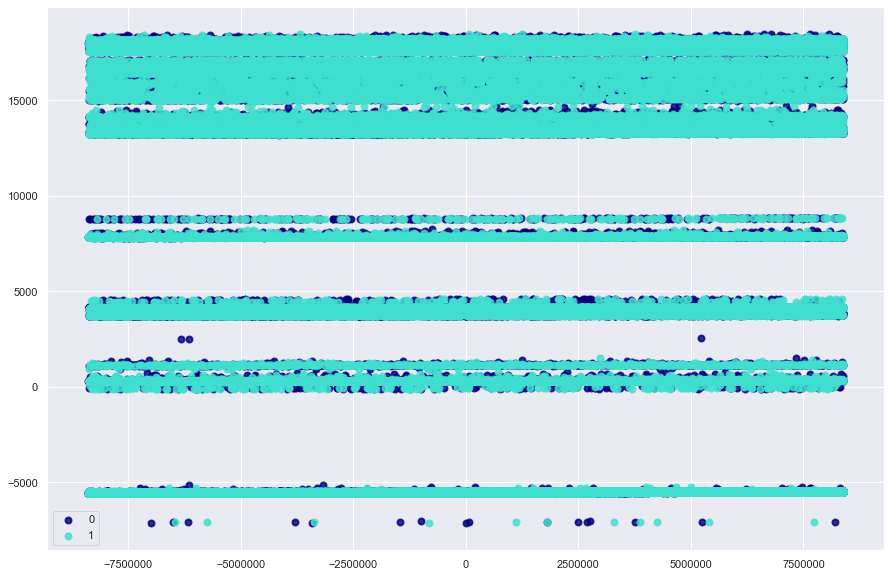

In [94]:
pca = PCA(n_components=2)
projected = pca.fit_transform(X_train)

plt.figure(figsize=(15,10))

from collections import defaultdict

category = defaultdict(list)
category[0].append('not-detected')
category[1].append('has-detections')

colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(projected[y_train==cat, 0], projected[y_train==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In both cases it is difficult to see the boundaries of the target variable.

### Simple decision tree
With correct feature selection (i.e. avoiding complete overfitting), we see that a tree does a better than the linear classifiers explored, and is on par with KNN and the best PCA/GMM approach.

It is after this classifer that we begin to explore our ensemble approaches with trees and gradient boosting.

In [70]:
# Model
model_name = "Decision Tree Classifier"
model = DecisionTreeClassifier()

Using Feature Selection through Correlation Analysis:

In [72]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Decision Tree Classifier using Correlated Feature Selection:

60.8% accuracy

confusion matrix
[[20156 13313]
 [12884 20558]]


Using Feature Selection through SelectFromModel:

In [71]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Decision Tree Classifier using SelectFromModel Feature Selection:

56.8% accuracy

confusion matrix
[[18985 14484]
 [14437 19005]]


## Emsembles

In this section we explore the different emsemble methods. We include a treatment of RandomForests and ExtraTrees for the standard tree classification approaches, and then we explored five different boosting options (three of which are presented here).

### Random Forest Classifier

We first look at RandomForest and ExtraTrees in the ensemble package. We note their results similar to each other, and, their results do not deviate much from EITHER method of feature selection.

In [73]:
# Model
model_name = "Random Forest Classifier"
model = RandomForestClassifier(n_estimators=20, random_state=0, n_jobs=-1)

Using Feature Selection through Correlation Analysis

In [75]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Random Forest Classifier using Correlated Feature Selection:

61.2% accuracy

confusion matrix
[[20087 13382]
 [12552 20890]]


Using Feature Selection through SelectFromModel:

In [74]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Random Forest Classifier using SelectFromModel Feature Selection:

62.1% accuracy

confusion matrix
[[22905 10564]
 [14819 18623]]


### Extra Trees Classifier

In [76]:
# Model
model_name = "Extra Trees Classifier"
model = ExtraTreesClassifier(n_estimators=20, min_samples_split=2,
                             random_state=0, n_jobs=-1)

Using Feature Selection through Correlation Analysis

In [78]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Extra Trees Classifier using Correlated Feature Selection:

61.1% accuracy

confusion matrix
[[20407 13062]
 [12995 20447]]


Using Feature Selection through SelectFromModel

In [77]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Extra Trees Classifier using SelectFromModel Feature Selection:

61.5% accuracy

confusion matrix
[[22545 10924]
 [14836 18606]]


### Gradient Boosting

Now we look at different methods for gradient boosting. It is here where see the SelectFromModel feature selection method outshine our old faithful Correlation Analysis method.

In [81]:
# Model
model_name = "Gradient Boosting Classifier"
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.6,
                                   max_depth=3, random_state=0)

Using Feature Selection through Correlation Analysis

In [82]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Gradient Boosting Classifier using Correlated Feature Selection:

63.1% accuracy

confusion matrix
[[20834 12635]
 [12036 21406]]


Using Feature Selection through SelectFromModel

In [83]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Gradient Boosting Classifier using SelectFromModel Feature Selection:

65.2% accuracy

confusion matrix
[[22014 11455]
 [11835 21607]]


### Ada Boost

In [84]:
# Model
model_name = "Ada Boosting Classifier"
model = AdaBoostClassifier(n_estimators=100, random_state=0)

Using Feature Selection through Correlation Analysis

In [85]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "Correlated"

    X_train = X_train_data_corr
    y_train = train_labels
    X_score = X_validate_data_corr
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Ada Boosting Classifier using Correlated Feature Selection:

62.6% accuracy

confusion matrix
[[19739 13730]
 [11301 22141]]


Using Feature Selection through SelectFromModel

In [86]:
# Feature Specifications

# disabled - we have better models and need to save time
if run_all_models:
    method = "SelectFromModel"

    X_train = X_train_data_sfm
    y_train = train_labels
    X_score = X_validate_data_sfm
    y_score = validate_labels

    # Generalized code below:

    score, cm = score_model(model, X_train, y_train, X_score, y_score)

    print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
    print(f"{100*score:0.1f}% accuracy\n")
    print("confusion matrix")
    print(cm)

Predicting with Ada Boosting Classifier using SelectFromModel Feature Selection:

63.6% accuracy

confusion matrix
[[21096 12373]
 [12015 21427]]


### LightGBM Gradient Booster

The LightGBM method of classification is available as an experimental library through HistGradientBoosting. Note that we also explored the XGBoost and CatBoost libraries. The LightGBM method stood out the best, and, it was a fast learner on our dataset.

In [87]:
#Model + estimator
model_name = "Light GBM Boosting Classifier"
est = HistGradientBoostingClassifier(learning_rate=.2,
                max_iter=100,
                max_bins=500,
                max_depth=-1,
                max_leaf_nodes=100,
                n_iter_no_change=None,
                random_state=0,
                verbose=0,
                loss='binary_crossentropy')
model = get_equivalent_estimator(est, lib='lightgbm')

Using Feature Selection through Correlation Analysis

In [88]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Light GBM Boosting Classifier using Correlated Feature Selection:

63.0% accuracy

confusion matrix
[[20973 12496]
 [12280 21162]]


Using Feature Selection through SelectFromModel

In [89]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

lightgbm_model = model

Predicting with Light GBM Boosting Classifier using SelectFromModel Feature Selection:

65.2% accuracy

confusion matrix
[[22186 11283]
 [11981 21461]]


## NeuralNetwork

<a href='#Contents'>[Back to top]</a>

To explore additional methods of predicting whether a machine had malware, we also built a Neural Network using Pytorch.  The original approach was load all the data at once and then let DataLoader to batch them for optimal training.

However, the CPU operations were intensive and the model (with the full dataset) would take several days to run.  As a result, one of our team members volunteered to use a CUDA-capable device at their employer. It was faster, but had limited video memory (8GB), so we needed to modify our approach to create smaller chunks of data and use loss-averaging.  The code that follows is this final output.

Please note that this section cannot really be run along with the rest of the model, apprently it is possible to overflow even a 64-bit heap. We have been a little careless with overall memory usage. What we ended up doing is include this model in runs with mini-sets, and start it separately, with its own data loading of the train set, when we wanted the full training on the GPU, and with separate loading of the test set for the creation of the official Kaggle submission.

In [6]:
# Setup hardware and loading parameters.

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_properties(device))
    chunk_size = 1000000 if not debug else 5 # run in meaningful chunks so that GPU doesn't run out of memory
    epochs = 300 # can do this in 90 min
else:
    device = torch.device('cpu')
    torch.set_num_threads(16) 
    print("running on CPU")
    chunk_size = 10000000 # load all the data at once
    if debug == True:
        epochs = 10 # run shorter because it takes a lot longer
    else:
        epochs = 100 # nobody has time for 300 without a GPU

    
class Model(nn.Module):
    '''This is the NN model.  Instantiation builds the hidden networks, sizes
    and dropout parameters based on the arguments provided'''
    def __init__(self, numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(numerical_cols).to(device)
        all_layers = []
        input_size = numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_data):
        x_data = self.batch_norm_num(x_data)
        x = torch.cat([x_data], 1)
        x = self.layers(x)
        return x

# Iterate and convert all data values
# work on the full dataset, let NN decide which columns are important

train_labels_long = train_labels.astype(np.int64)

cols = []
for c in train_data.columns:
    train_data[c] = train_data[c].astype(np.float64) # Convert dtypes to be all identical for pytorch

# This Instantiates the model with 150 inputs, 4 hidden layers and 2 outputs.
model = Model(len(train_data.columns), 2, [180,50,50,20], p=0.4).to(device)

# Using CrossEntropyLoss because we effectively have an unbalanced training set
# In other words, not all inputs are normalized
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Starting NN training")
start = time.time()

for i in range(epochs):
    
    print(f' Epoch: {i+1:3d}:', end=' ')
    
    rows_left = len(train_data)
    current = 0
    chunk_num = math.ceil(rows_left/chunk_size)

    #
    # do every epoch in chunks
    #
    
    model.zero_grad()
    while rows_left > 0:
        rows = (chunk_size if rows_left >= chunk_size else rows_left)
        chunk = train_data[current:current+rows]
        label_chunk = train_labels_long[current:current+rows].values
        
        current += rows
        rows_left -= rows
        
        print(".", end="")
        
        # grab columns and labels, push into device (possibly GPU)
        cols = [chunk[col].values for col in chunk.columns]
        data = np.stack(cols, 1)
        data = torch.tensor(data, dtype=torch.float).to(device)
        target = torch.tensor(label_chunk).to(device)
        
        prediction = model(data)
        single_loss = loss_function(prediction, target)
        single_loss /= chunk_num # important to average the loss with this chunked method
        # todo: this is possibly incorrect if the chunks are not all even (the last one might be smaller)
        single_loss.backward()

    # after done with all chunks, process the step and reset the gradients
    optimizer.step()
    model.zero_grad()
      
    print(f', loss: {single_loss.item()*chunk_num:1.3f},', end=' ')
    print(f'elapsed: {time.time()-start:5.0f} s')

    

running on CPU
Starting NN training
 Epoch:   1: ., loss: 0.786, elapsed:    21 s
 Epoch:   2: ., loss: 0.768, elapsed:    41 s
 Epoch:   3: ., loss: 0.754, elapsed:    62 s
 Epoch:   4: ., loss: 0.746, elapsed:    82 s
 Epoch:   5: ., loss: 0.737, elapsed:   103 s
 Epoch:   6: ., loss: 0.731, elapsed:   123 s
 Epoch:   7: ., loss: 0.726, elapsed:   144 s
 Epoch:   8: ., loss: 0.723, elapsed:   166 s
 Epoch:   9: ., loss: 0.718, elapsed:   186 s
 Epoch:  10: ., loss: 0.714, elapsed:   206 s
 Epoch:  11: ., loss: 0.708, elapsed:   226 s
 Epoch:  12: ., loss: 0.706, elapsed:   246 s
 Epoch:  13: ., loss: 0.703, elapsed:   266 s
 Epoch:  14: ., loss: 0.700, elapsed:   286 s
 Epoch:  15: ., loss: 0.698, elapsed:   306 s
 Epoch:  16: ., loss: 0.694, elapsed:   326 s
 Epoch:  17: ., loss: 0.693, elapsed:   345 s
 Epoch:  18: ., loss: 0.688, elapsed:   365 s
 Epoch:  19: ., loss: 0.687, elapsed:   385 s
 Epoch:  20: ., loss: 0.686, elapsed:   405 s
 Epoch:  21: ., loss: 0.684, elapsed:   426 

In [7]:
#
# Eval phase
#

model.eval() # switch into eval mode
model.cpu() # get model back into CPU space

# Iterate and convert all data values

test=validate_data
test_labels_long = validate_labels.astype(np.int64)

cols = []
for c in test.columns:
    test[c] = test[c].astype(np.float64) # Convert dtypes to be all identical for pytorch

print(f"Test data: {len(test)} rows, {len(test.columns)} columns")

# grab columns and labels
cols = [test[col].values for col in test.columns]
data = np.stack(cols, 1)
data = torch.tensor(data, dtype=torch.float)

# Make prediction on dev data
output = model(data)
predictions = np.argmax(output.data.numpy(), axis=1)

# Print NN accuracy and some sample predictions
print("\naccuracy:", metrics.accuracy_score(y_true=validate_labels, y_pred=predictions))
cm = confusion_matrix(validate_labels, predictions)
print("\nconfusion matrix")
print(cm)

nn_model = model

Test data: 66911 rows, 148 columns

accuracy: 0.619165757498767

confusion matrix
[[21234 12235]
 [13247 20195]]


## Submissions

We created two submission entries for kaggle from our two best performers. We obtained results that met our goal of 60%. We got 61.6% from the Light GBM method and 60.4% from our Pytorch Neural Net.

In [ ]:
# Create submission files for our top contenders
# Note there is no debug version of this. We don't have all the minis we need. This just takes a while.

# Import test DF from CSV
print('loading unlabeled test data ...')
submission_test_file_name = 'data/test_encoded.csv'
df_submission_test = load_from_encoded_data(submission_test_file_name)

In [ ]:
# we split out the machine-ids earlier. Now we need them again.

print('loading machine identifiers ...')
if generate_ids:
    df_submission_test_machine_ids = load_from_raw_data('data/test.csv')
    machine_ids = df_submission_test_machine_ids['MachineIdentifier']
    machine_ids.to_csv('data/test_ids.csv', header=True)
else:
    machine_ids = pd.read_csv('data/test_ids.csv', engine='c', header=0)['MachineIdentifier']
    

In [ ]:
# NN submission
# Iterate and convert all data values

print("testing using NN ...")
test = df_submission_test
cols = []
for c in test.columns:
    test[c] = test[c].astype(np.float64) # Convert dtypes to be all identical for pytorch

print(f"Test data: {len(test)} rows, {len(test.columns)} columns")

# grab columns and labels
cols = [test[col].values for col in test.columns]
data = np.stack(cols, 1)
data = torch.tensor(data, dtype=torch.float)

# Make prediction on large test data
output = nn_model(data)
predictions = np.argmax(output.data.numpy(), axis=1)
print('done with NN predictions.')

In [ ]:
print('making NN submission frame and saving ...')
cols = {'MachineIdentifier':machine_ids, 'HasDetections':predictions}
submission_df = pd.DataFrame(cols, columns=['MachineIdentifier', 'HasDetections'])
submission_df.to_csv("data/nn-submission.csv", index=False)
print('done making NN submission file')

In [ ]:
# lightgbm submission
print('making LightGBM submission frame and saving ...')
sfm_features =  sfm.transform(df_submission_test)
predictions = lightgbm_model.predict(sfm_features)

cols = {'MachineIdentifier':machine_ids, 'HasDetections':predictions}
submission_df = pd.DataFrame(cols, columns=['MachineIdentifier', 'HasDetections'])
submission_df.to_csv("data/lightgbm-submission.csv", index=False)
print('done making LightGBM submission file')

## Conclusion

<a href='#Contents'>[Back to top]</a>

### The state of affairs

Forecasting whether a machine is about to be infected with malware is difficult. Beating 60% doesn't sound like much of a goal until you take a look at the data and fully understand how generic and useless it is. Privacy concerns must have have trumped usability for the collection. Our work didn't move the needle in this space, but the problem was an instructive plaground on which we tried a number of approaches. 

### Things that worked

For some models, automatic feature selection with an ExtraTrees classifier was worthwhile. For others, adding columns manually and keep the beneficial ones was a much better approach. That seemed surprising to us. We suspect that much of the meaningful information in this set is non-linear, making it hard to find unless we knew what we were looking for. Consequently, we had high hopes for a neural net trained on volumes of data. It did o.k. on the official test, at just over 60%, but had to bow to the LightGBM classifier at 61+%. 

### Things that proved fruitless

Even with some experimentation, some of the models were just not well-suited to this task. Logistic Regression was hopeless for this, as were some other classifiers and ensemble methods that never did better than basic coin-toss. 

### Learnings we take away

1. Bite off only what you can chew. If we want to compete on a big Kaggle set, let's spend the money and rent cloud hardware for the duration. If it seems to expensive, that's a clue that this problem is probably a bit too big for us. In general, we would like to have 10 times the amount of main memory compared to the size of the data set. And at least 100 times the free disk space.

2. Iterate faster. We have no illusion that we are done learning important things abot this process. We learned little when we focused on details, and large first-order bits when we iterated the full cycle. It is crucial to quickly derive mini sets of uncleaned and cleaned data in order to make fast iteration possible.

### Things we would still like to do

I think all three of us would like more time tuning the most promising models. We only found out too late that adding layers to the neural net comes at basically no extra cost, within reasonable limits, on the hardware we used. On LightGBM, we would play with more settings to see wher this could take us. 

We are also a) disappointed with Colab, which would unpredictably be too slow to work as a group at all, and b) excited about renting cheap cloud hardware with a TPU and a little bit of storage, to perform our NN experiments there. There is still a lot we have to learn and improve when it comes to transforming data efficiently, and into formats that suit those TPUs well.

There is also a statistical dimension to our data that we did not fully embrace at the beginning. Not all machines that are ripe for it get hit with attacks. GMM still sounds like an appealing way to treat the problem, albeit after some non-linear form of dimensionality reduction.

### In closing

It has been an illuminating 3 weeks for our group. Arguably, we spent at least half of our time, if not a lot more, copying data from place to place, and reading, cleaning, and writing those data. We set out to do a short survey of how far classical models could get us for this problem, and to try a neural network, and in the end, we just got all of these to work, rather than spending quality time with them and fine-tuning their parameters.

That's not to say that we regret our choice. We learned a lot about how to think about processes like cleaning and normalizing data, and we have a lot more perspective on what makes an approach workable. We actually did apply a few ensemble methods, and actually trained a neural net with a massive amount of data. Before this project, we only had a loose idea of what this would entail.